In [1]:
from IPython import display

import msprime
import numpy as np
import tskit

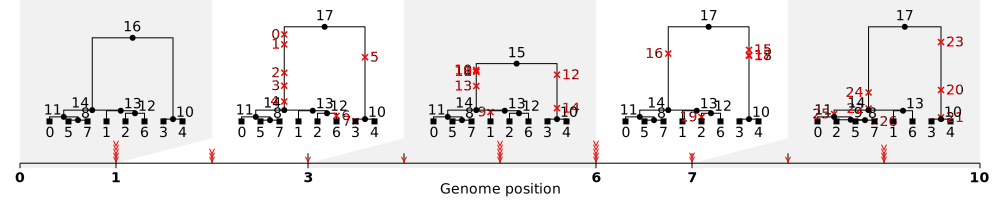

In [220]:
# ts = tskit.load("../tree-simple-1.tree")
ts = tskit.load("../test.tree")
ts.draw_svg()

In [192]:
def next_state_at(ts, tj, tk, t_left, sample_sets, parent=None, state=None):
    I = ts.indexes_edge_insertion_order
    O = ts.indexes_edge_removal_order
    parent = -np.ones(ts.num_nodes, dtype=np.int32) if parent is None else parent

    state = np.zeros((ts.num_nodes, len(sample_sets)), dtype=np.int32) if state is None else state

    for i, sample_set in enumerate(sample_sets):
        state[sample_set, i] = 1
    
    while (tk < ts.num_edges) and (ts.edges_right[O[tk]] == t_left):
        h = O[tk]
        tk += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
    
        while (v != -1):
            # print(state[u])
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.a{v}.n{u} > .edge {{stroke: red; stroke-width: 2px}}'))
            state[v] += -state[u]
            v = parent[v]
        parent[u] = -1
    while (tj < ts.num_edges) and (ts.edges_left[I[tj]] == t_left):
        h = I[tj]
        tj += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
        parent[u] = v
        while (v != -1):
            # print(state[u])
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.a{v}.n{u} > .edge {{stroke: cyan; stroke-width: 2px}}'))
            state[v] += state[u]
            v = parent[v]
    t_right = ts.sequence_length
    if (tj < ts.num_edges):
        t_right = min(t_right, ts.edges_left[I[tj]])
    if (tk < ts.num_edges):
        t_right = min(t_right, ts.edges_right[O[tk]])

    t_left = t_right
    return tj, tk, t_left, parent, state

In [193]:
def track_ab_haplotypes(ts, tk, tj, t_left, state):
    I = ts.indexes_edge_insertion_order
    O = ts.indexes_edge_removal_order

    mut_parent = ts.edge(ts.mutation(0).edge).parent
    if ts.edges_parent[mut_parent - 1] == mut_parent:
        prune_edge = mut_parent - 1
    elif ts.edges_parent[mut_parent + 1] == mut_parent:
        prune_edge = mut_parent + 1
    else:
        raise Exception('Unexpected condition')

    state = state.copy()
    state[ts.edge(prune_edge).parent] -= state[ts.edge(prune_edge).child]

    stack = []
    stack.append(ts.edge(prune_edge).child)
    while len(stack) > 0:
        node = stack.pop()
        state[node] -= state[node]
        if right_child[node] != -1:
            stack.append(right_child[node])
        if left_child[node] != -1:
            stack.append(left_child[node])

    # walk over the edge diffs for the next tree
    while out < ts.num_edges and ts.edges_right[O[out]] == t_left:
        k = O[out]
        out += 1
        # NB redefine u here
        u = ts.edges_parent[k]
        c = ts.edges_child[k]
        state[u] -= state[c]
        # print(f'removed {k} {u} {c}')
    while i < ts.num_edges and ts.edges_left[I[i]] == t_left:
        k = I[i]
        i += 1
        u = ts.edges_parent[k]
        c = ts.edges_child[k]
        state[u] += state[c]
        # print(f'added {k} {u} {c}')

In [261]:
def get_allele_weights(site, state):
    allele_mat = np.zeros((len(site.mutations) + 1, len(sample_sets)))
    allele_states = [site.ancestral_state]
    num_alleles = 1
    allele = 0
    allele_mat[allele] = np.array(list(map(len, sample_sets)))
    for mutation in site.mutations:

        if mutation.derived_state in allele_states:
            allele = allele_states.index(mutation.derived_state)
        else:
            allele_states.append(mutation.derived_state)
            allele = len(allele_states) - 1
            num_alleles += 1
        allele_mat[allele] += state[mutation.node]

        alt_allele = allele_states.index(site.ancestral_state)
        if mutation.parent != -1:
            # TODO haven't exercised this code path yet
            alt_allele = allele_states.index(site.mutations[mutation.parent - site.mutations[0].id].derived_state)
        allele_mat[alt_allele] -= state[mutation.node]

    allele_state.append((len(allele_states), allele_mat))
    return num_alleles, allele_mat

In [221]:
ts.num_sites

9

In [229]:
def combos_w_replacement(n, k):
    return np.math.factorial(n + k - 1) / (np.math.factorial(k) * np.math.factorial(n - 1))

In [230]:
combos_w_replacement(9, 2)

45.0

In [199]:
next_state_at(
ts=ts, tj=0, tk=0, t_left=0,
sample_sets=sample_sets, parent=None, state=None
)

(14,
 0,
 1.0,
 array([11, 13, 12, 10, 10,  8, 12,  8, 11, -1, 16, 14, 13, 14, 16, -1, -1,
        -1], dtype=int32),
 array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [0],
        [2],
        [3],
        [2],
        [3],
        [6],
        [0],
        [8],
        [0]], dtype=int32))

In [263]:
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]
# sample_sets = [[0, 1, 2]]
sample_sets = [list(ts.samples())]

allele_state = []

tj_left = 0
tk_left = 0
t_left_left = 0
tree_index_left = 0
parent_left = None
state_left = None

tj_right = 0
tk_right = 0
t_left_right = 0
tree_index_right = 0
parent_right = None
state_right = None

last = False


while (tj_left < ts.num_edges) or (t_left_left < ts.sequence_length):
    treeseq_state_left = next_state_at(
        ts=ts, tj=tj_left, tk=tk_left, t_left=t_left_left,
        sample_sets=sample_sets, parent=parent_left, state=state_left
    )
    tj_left, tk_left, t_left_left, parent_left, state_left = treeseq_state_left
    tj_right, tk_right, t_left_right, parent_right, state_right = treeseq_state_left
    parent_right = parent_right.copy()
    state_right = state_right.copy()
    tree_index_right = tree_index_left
    if (tj_right >= ts.num_edges) or (t_left_right >= ts.sequence_length):
        last = True

    while (tj_right < ts.num_edges) or (t_left_right < ts.sequence_length) or last:
        if tree_index_left != tree_index_right:
            treeseq_state_right = next_state_at(
                ts=ts, tj=tj_right, tk=tk_right, t_left=t_left_right,
                sample_sets=sample_sets, parent=parent_right, state=state_right
            )
            tj_right, tk_right, t_left_right, parent_right, state_right = treeseq_state_right

        num_sites_left = ts.at_index(tree_index_left).num_sites
        num_sites_right = ts.at_index(tree_index_right).num_sites
        left_sites = list(ts.at_index(tree_index_left).sites())  # ts->tree_sites[tree_index_left]
        right_sites = list(ts.at_index(tree_index_right).sites())

        if tree_index_left != tree_index_right:
            for i in range(num_sites_left):
                for j in range(num_sites_right):
                    left_site = left_sites[i]
                    right_site = right_sites[j]
                    num_alleles_left, allele_mat_left = get_allele_weights(left_site, state_left)
                    num_alleles_right, allele_mat_right = get_allele_weights(right_site, state_right)
        else:
            assert num_sites_left == num_sites_right
            for i, j in pairs_with_replacement(num_sites_left):
                left_site = left_sites[i]
                right_site = right_sites[j]
                num_alleles_left, allele_mat_left = get_allele_weights(left_site, state_left)
                num_alleles_right, allele_mat_right = get_allele_weights(right_site, state_right)
                
        if last:
            break
        tree_index_right += 1
    tree_index_left += 1

# for _n_alleles, _a_state in allele_state:
#     print(_a_state)
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]

In [266]:
allele_mat_left

array([[3.],
       [2.],
       [2.],
       [1.],
       [0.]])

In [267]:
num_alleles_left

4

In [255]:
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]
# sample_sets = [[0, 1, 2]]
sample_sets = [list(ts.samples())]

allele_state = []

tj_left = 0
tk_left = 0
t_left_left = 0
tree_index_left = 0
parent_left = None
state_left = None

tj_right = 0
tk_right = 0
t_left_right = 0
tree_index_right = 0
parent_right = None
state_right = None

last = False

while (tj_left < ts.num_edges) or (t_left_left < ts.sequence_length):
    treeseq_state_left = next_state_at(
        ts=ts, tj=tj_left, tk=tk_left, t_left=t_left_left,
        sample_sets=sample_sets, parent=parent_left, state=state_left
    )
    tj_left, tk_left, t_left_left, parent_left, state_left = treeseq_state_left
    tj_right, tk_right, t_left_right, parent_right, state_right = treeseq_state_left
    parent_right = parent_right.copy()
    state_right = state_right.copy()
    tree_index_right = tree_index_left
    if (tj_right >= ts.num_edges) or (t_left_right >= ts.sequence_length):
        last = True

    while (tj_right < ts.num_edges) or (t_left_right < ts.sequence_length) or last:
        if tree_index_left != tree_index_right:
            treeseq_state_right = next_state_at(
                ts=ts, tj=tj_right, tk=tk_right, t_left=t_left_right,
                sample_sets=sample_sets, parent=parent_right, state=state_right
            )
            tj_right, tk_right, t_left_right, parent_right, state_right = treeseq_state_right

        # for site in ts.at_index(tree_index_left).sites():  # ts->tree_sites[tree_index_left]
        #     allele_mat = get_allele_weights(site, state_left)
        num_sites_left = ts.at_index(tree_index_left).num_sites
        num_sites_right = ts.at_index(tree_index_right).num_sites
        left_sites = list(ts.at_index(tree_index_left).sites())
        right_sites = list(ts.at_index(tree_index_right).sites())

        if tree_index_left != tree_index_right:
            # print('tree', tree_index_left, state_left.reshape(-1))
            # print('tree', tree_index_right, state_right.reshape(-1))
            for i, j in pairs_with_replacement(num_sites_left + num_sites_right):
                left_site = left_sites[i] if i < num_sites_left else right_sites[i - num_sites_left]
                right_site = left_sites[j] if j < num_sites_left else right_sites[j - num_sites_left]
                allele_mat_left = get_allele_weights(left_site, state_left)
                allele_mat_right = get_allele_weights(right_site, state_right)
                # print('tree_index', tree_index_left, tree_index_right)
                print('site_id', left_site.id, right_site.id)
                # print(allele_mat_left, allele_mat_right, sep='\n')
                print('-------')

        # print(tree_index_left, tree_index_right)
        # print('-------')

        if last:
            break
        tree_index_right += 1
    tree_index_left += 1

# for _n_alleles, _a_state in allele_state:
#     print(_a_state)
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]

site_id 0 0
-------
site_id 0 1
-------
site_id 1 1
-------
site_id 2 2
-------
site_id 2 3
-------
site_id 2 4
-------
site_id 3 3
-------
site_id 3 4
-------
site_id 4 4
-------
site_id 5 5
-------
site_id 6 6
-------
site_id 6 7
-------
site_id 6 8
-------
site_id 7 7
-------
site_id 7 8
-------
site_id 8 8
-------
site_id 0 0
-------
site_id 0 1
-------
site_id 0 2
-------
site_id 0 3
-------
site_id 0 4
-------
site_id 1 1
-------
site_id 1 2
-------
site_id 1 3
-------
site_id 1 4
-------
site_id 2 2
-------
site_id 2 3
-------
site_id 2 4
-------
site_id 3 3
-------
site_id 3 4
-------
site_id 4 4
-------
site_id 0 0
-------
site_id 0 1
-------
site_id 0 5
-------
site_id 1 1
-------
site_id 1 5
-------
site_id 5 5
-------
site_id 0 0
-------
site_id 0 1
-------
site_id 0 6
-------
site_id 0 7
-------
site_id 0 8
-------
site_id 1 1
-------
site_id 1 6
-------
site_id 1 7
-------
site_id 1 8
-------
site_id 6 6
-------
site_id 6 7
-------
site_id 6 8
-------
site_id 7 7
-------


In [202]:
treeseq_state_right = next_state_at(
    ts=ts, tj=tj_right, tk=tk_right, t_left=t_left_right,
    sample_sets=sample_sets, parent=parent_right, state=state_right
)
tj_right, tk_right, t_left_right, parent_right, state_right = treeseq_state_right

In [ ]:
state_left

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [0],
       [2],
       [3],
       [2],
       [3],
       [6],
       [0],
       [0],
       [8]], dtype=int32)

In [197]:
parent_left

array([11, 13,  9, 10, 10,  8, 13,  8,  9, 11, 17, 14, -1, 14, 17, -1, -1,
       -1], dtype=int32)

In [198]:
parent_right

array([11, 13,  9, 10, 10,  8, 13,  8,  9, 11, 17, 14, -1, 14, 17, -1, -1,
       -1], dtype=int32)

[ 1  1  1  1  1  1  1  1  2 15  2 38 -8 18  6 -8 -8 24]


In [137]:
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]
sample_sets = [[0, 1, 2]]

allele_state = []

tj_left = 0
tk_left = 0
t_left_left = 0
tree_index_left = 0
parent_left = None
state_left = None

tj_right = 0
tk_right = 0
t_left_right = 0
tree_index_right = 0
parent_right = None
state_right = None

at_end = 1

while (tj_left < ts.num_edges) or (t_left_left < ts.sequence_length):
    if at_end:
        treeseq_state_left = next_state_at(
            ts=ts, tj=tj_left, tk=tk_left, t_left=t_left_left,
            tree_index=tree_index_left, sample_sets=sample_sets, parent=parent_left, state=state_left
        )
        tj_left, tk_left, t_left_left, tree_index_left, state_left = treeseq_state_left
        tj_right, tk_right, t_left_right, tree_index_right, state_right = treeseq_state_left

    if (tj_right >= ts.num_edges) or (t_left_right >= ts.sequence_length):
        at_end = 1
    elif at_end:
        pass
    else:
        treeseq_state_right = next_state_at(
            ts=ts, tj=tj_right, tk=tk_right, t_left=t_left_right,
            tree_index=tree_index_right, sample_sets=sample_sets, parent=parent_right, state=state_right
        )
        tj_right, tk_right, t_left_right, tree_index_right, state_right = treeseq_state_right

    # for site in ts.at_index(tree_index_left).sites():  # ts->tree_sites[tree_index_left]
    #     allele_mat = get_allele_weights(site, state_left)
    num_sites_left = ts.at_index(tree_index_left).num_sites
    num_sites_right = ts.at_index(tree_index_right).num_sites
    left_sites = list(ts.at_index(tree_index_left).sites())
    right_sites = list(ts.at_index(tree_index_right).sites())

    # print(num_sites_left, num_sites_right)
    # print([
    #     (
    #         i if i < num_sites_left else i - num_sites_left,
    #         j if j < num_sites_left else j - num_sites_left
    #     )
    #     for i, j in pairs_with_replacement(num_sites_left + num_sites_right)
    # ])
    print(tree_index_left, tree_index_right)
    print('-------')
    # for i, j in pairs_with_replacement(num_sites_left + num_sites_right):
    #     left_site = left_sites[i] if i < num_sites_left else right_sites[i - num_sites_left]
    #     right_site = left_sites[j] if j < num_sites_left else right_sites[j - num_sites_left]
    #     allele_mat_left = get_allele_weights(left_site, state_left)
    #     allele_mat_right = get_allele_weights(right_site, state_right)
    #     print(tree_index_left, tree_index_right)
    #     print(left_site.id, right_site.id)
    #     print(allele_mat_left, allele_mat_right, sep='\n')
    #     print('-------')

    if at_end:
        tree_index_left += 1
        at_end = 0
        tree_index_right = 0
    else:
        tree_index_right += 1

# for _n_alleles, _a_state in allele_state:
#     print(_a_state)
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]

0 0
-------
1 0
-------
1 1
-------


IndexError: Index out of bounds

In [130]:
left_sites

[Site(id=1, position=14.0, ancestral_state='G', mutations=[Mutation(id=1, site=1, node=2, derived_state='A', parent=-1, metadata=b'', time=nan, edge=6)], metadata=b'')]

In [99]:
state_left

array([[1],
       [1],
       [1],
       [0],
       [0],
       [2],
       [3]], dtype=int32)

In [98]:
state_right

array([[1],
       [1],
       [1],
       [0],
       [0],
       [2],
       [3]], dtype=int32)

In [79]:
def pairs_with_replacement(n):
    subloop_start = 0
    for i in range(n):
        for j in range(subloop_start, n):
            yield i, j
        subloop_start += 1

In [126]:
# yyy = ['x', 'y', 'z']
# zzz = ['a', 'b', 'c', 'd', 'e']
yyy = ['y']
zzz = ['z']

ppp = [
    (yyy[yyy_i] if yyy_i < len(yyy) else zzz[yyy_i - len(yyy)],
     yyy[zzz_i] if zzz_i < len(yyy) else zzz[zzz_i - len(yyy)])
    for yyy_i, zzz_i in list(pairs_with_replacement(len(yyy) + len(zzz)))
]

from itertools import combinations_with_replacement
list(combinations_with_replacement(yyy + zzz, 2)) == ppp

True

In [17]:
allele_mat

array([[2.],
       [1.]])

In [18]:
state_left

array([[1],
       [1],
       [1],
       [0],
       [0],
       [2],
       [3]], dtype=int32)

In [5]:
def diversity_summary_func(state, sample_sets):
    x = state
    n = np.array([len(ss) for ss in sample_sets])  # sample_set_sizes
    return x * (n - x) / (n * (n - 1))

In [6]:
stats = []
for _n_alleles, _a_state in allele_state:
    for i in range(_n_alleles):  # If polarized, range from 1
        stats.append(diversity_summary_func(_a_state[i], sample_sets))

In [7]:
np.vstack(stats).sum(0)

ValueError: need at least one array to concatenate

In [8]:
# display.display(display.Markdown("# Edge Insertion Order"))
# for i in I:
#     edge = ts.edge(i)
#     display.display(ts.draw_svg(style=f'.a{edge.parent}.n{edge.child} > .edge {{stroke: cyan; stroke-width: 2px}}'))

In [8]:
# display.display(display.Markdown("# Edge Removal Order"))
# for i in O:
#     edge = ts.edge(i)
#     display.display(ts.draw_svg(style=f'.a{edge.parent}.n{edge.child} > .edge {{stroke: cyan; stroke-width: 2px}}'))